In [198]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from Bio.SeqIO.FastaIO import SimpleFastaParser
import os
from upsetplot import UpSet
from upsetplot import from_contents

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

#run_type = "dry"
run_type = "wet"


new_day = datetime.datetime.now().strftime("%Y%m%d")

palette = {"Control":"#000000", "Rapa Adult":"#5a9f68", 
           "Rapa Early":"#4170b0", "Rapa Late":"#c34e0d"}

path = "../analysis/plots/new_plots_forYuXuan/"

In [199]:
# Read fasta with ASV names to put OTU into our dataframe
with open('../analysis/CLEAN_ASVs_merged.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID
        seqs.append(sequence)

fasta_tuples = list(zip(identifiers, seqs))
df_fa = pd.DataFrame(fasta_tuples, columns = ["OTU", "sequence"])

In [200]:
# Define the directory containing the files
data_dir = "../analysis/deseq_timepoints_new/"

# List all files in the directory
all_files = os.listdir(data_dir)
csv_files = [f for f in all_files if f.endswith(".csv")]
csv_files = [f for f in csv_files if f.startswith("AGE_")]

# Create an empty dictionary to store dataframes
data_dict = {}

# Loop through each file
for filename in csv_files:
    # Extract key (filename before second underscore)
    #key = '_'.join(filename.split("_")[0:4])
    key = filename
  
    # Read the file and store in the dictionary
    data_dict[key] = pd.read_csv(os.path.join(data_dir, filename), sep=";")

# Concatenate the dataframes using the dictionary
mat = pd.concat(data_dict.values(), keys=data_dict.keys())

In [201]:
mat.reset_index(inplace = True)
mat.columns = ["fullname", "trash", "sequence", 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
mat.drop(columns = ["trash"], inplace = True)

In [202]:
# Make a tax column to compare to lefse
mat["tax"] = mat[["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].astype(str).agg("_".join, axis = 1)
mat["tax"] = list(mat["tax"].str.replace("_nan", "_NA"))

# Merge matrix with FC and stuff with the correspondence to otu name
mer = pd.merge(mat, df_fa, how = "left", on = "sequence")

In [203]:
di = {'AGE_Mid_Old_Rapa Early_20240606.csv':"MidOld_RapaEarly",
       'AGE_YoungRapa Adult_OldRapa Early_Rapa Early_20240606.csv':"YoungRapaAdult_OldRapaEarly",
       'AGE_MidRapa Adult_OldRapa Late_Rapa Early_20240606.csv':"MidRapaAdult_OldRapaLate",
       'AGE_YoungRapa Adult_MidRapa Early_Rapa Early_20240606.csv':"YoungRapaAdult_MidRapaEarly",
       'AGE_Young_Mid_Control_20240606.csv':"YoungMid_Control",
       'AGE_Mid_Old_Control_20240606.csv':"MidOld_Control",
       'AGE_Young_Mid_Rapa Adult_20240606.csv':"YoungMid_RapaAdult",
       'AGE_Young_Old_Rapa Adult_20240606.csv':"YoungOld_RapaAdult",
       'AGE_Mid_Old_Rapa Adult_20240606.csv':"MidOld_RapaAdult",
       'AGE_MidControl_OldRapa Late_Rapa Early_20240606.csv':"MidControl_OldRapaLate",
       'AGE_Young_Old_Control_20240606.csv':"YoungOld_Control"}
mer = mer.replace({"fullname": di})

In [204]:
merX = mer[mer["log2FoldChange"] > 0]

In [205]:
RapaAdult_YoungOld = merX[merX["fullname"] == "YoungOld_RapaAdult"]["OTU"]
RapaAdult_MidOld = merX[merX["fullname"] == "MidOld_RapaAdult"]["OTU"]
RapaAdult_YoungMid = merX[merX["fullname"] == "YoungMid_RapaAdult"]["OTU"]

Control_YoungOld = merX[merX["fullname"] == "YoungOld_Control"]["OTU"]
Control_MidOld = merX[merX["fullname"] == "MidOld_Control"]["OTU"]
Control_YoungMid = merX[merX["fullname"] == "YoungMid_Control"]["OTU"]

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_80667/2810824567.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


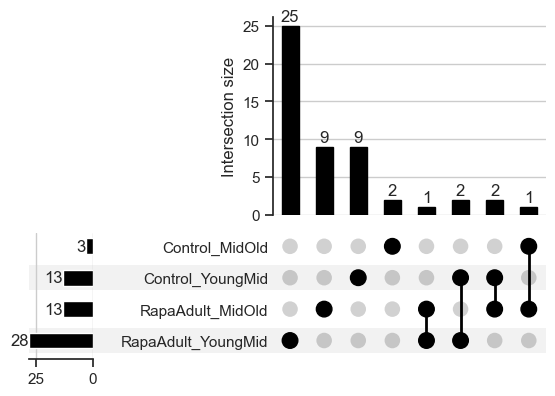

In [206]:
changes = from_contents(
    {"RapaAdult_YoungMid": RapaAdult_YoungMid, "RapaAdult_MidOld": RapaAdult_MidOld,
    "Control_MidOld":Control_MidOld, "Control_YoungMid":Control_YoungMid}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig(f"{path}/Upregulated_uppset.pdf")

In [207]:
pd.Series(list(set(RapaAdult_YoungMid) & set(RapaAdult_MidOld)))

0    ASV_89
dtype: object

In [208]:
merX = mer[mer["log2FoldChange"] < 0]

In [209]:
RapaAdult_YoungOld = merX[merX["fullname"] == "YoungOld_RapaAdult"]["OTU"]
RapaAdult_MidOld = merX[merX["fullname"] == "MidOld_RapaAdult"]["OTU"]
RapaAdult_YoungMid = merX[merX["fullname"] == "YoungMid_RapaAdult"]["OTU"]

Control_YoungOld = merX[merX["fullname"] == "YoungOld_Control"]["OTU"]
Control_MidOld = merX[merX["fullname"] == "MidOld_Control"]["OTU"]
Control_YoungMid = merX[merX["fullname"] == "YoungMid_Control"]["OTU"]

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_80667/953847550.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


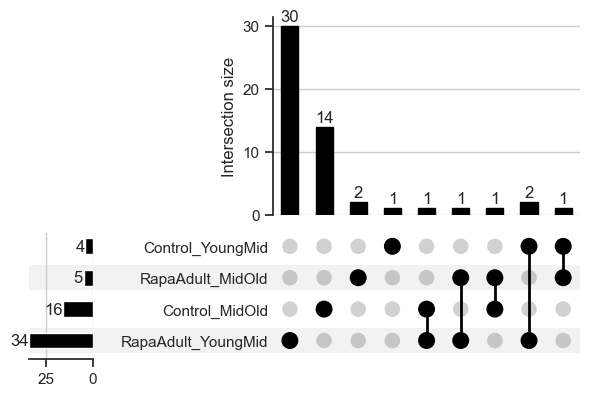

In [210]:
changes = from_contents(
    {"RapaAdult_YoungMid": RapaAdult_YoungMid, "RapaAdult_MidOld": RapaAdult_MidOld,
    "Control_MidOld":Control_MidOld, "Control_YoungMid":Control_YoungMid}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig(f"{path}/Downregulated_uppset.pdf")

In [211]:
pd.Series(list(set(RapaAdult_YoungMid) & set(RapaAdult_MidOld)))

0    ASV_93
dtype: object

In [212]:
upreg = mer[mer["log2FoldChange"] > 0]
upreg["reg"] = "up_in_older"
downreg = mer[mer["log2FoldChange"] < 0]
downreg["reg"] = "down_in_older"

mer = pd.concat([upreg, downreg])

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_80667/31300130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upreg["reg"] = "up_in_older"
/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_80667/31300130.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downreg["reg"] = "down_in_older"


In [213]:
## Do chronics
chronics = mer[mer["fullname"].isin(["YoungMid_RapaAdult",
                                  'YoungMid_Control',
                                   'MidOld_Control',
                                  'MidOld_RapaAdult'])]

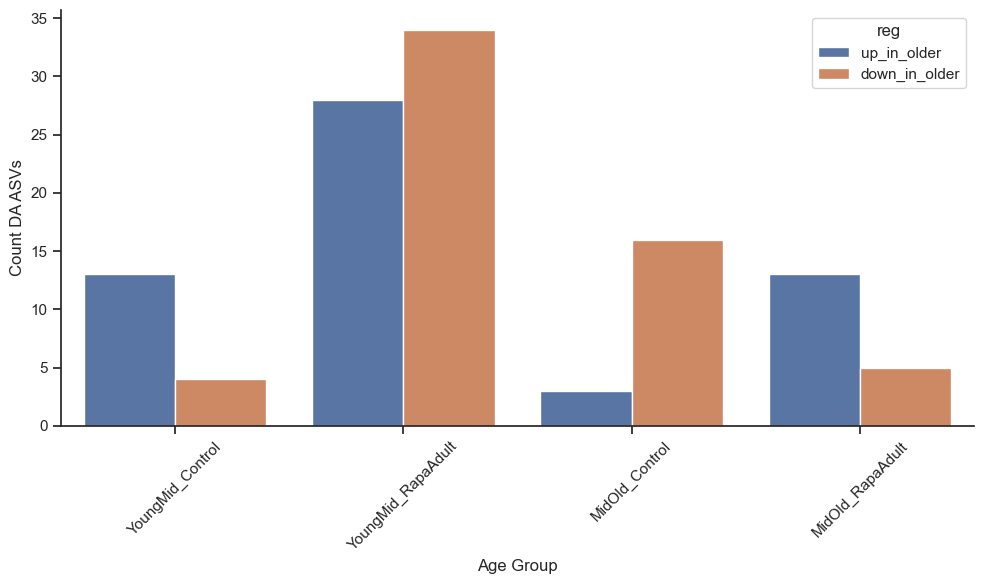

In [214]:
palettesex = {'AGE_Young_Mid_Control_20240606.csv': '#000000',
 'AGE_Young_Mid_Rapa Adult_20240606.csv': '#c34e0d',
 'AGE_Mid_Old_Control_20240606.csv': '#000000',
 'AGE_Mid_Old_Rapa Adult_20240606.csv': '#c34e0d'}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

fig, ax = plt.subplots(figsize = (10, 6))
# Create the bar plot
sns.countplot(chronics, x="fullname",
             order = ['YoungMid_Control', 
            "YoungMid_RapaAdult", 'MidOld_Control',
            'MidOld_RapaAdult'], hue = "reg")

plt.xlabel("Age Group")
plt.ylabel("Count DA ASVs")
plt.xticks(rotation=45)  # rotate x-axis labels for better readability

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig(f"{path}/RapavControl_barplot.pdf")
plt.savefig(f"{path}/RapavControl_barplot.png")

## Plot expression of these bacteria

In [181]:
norm_otu = pd.read_csv("../analysis/norm-CLEAN_ASVs_counts_merged_20240530.tsv", sep = "\t")
norm_otu.set_index('Sample_ID', inplace = True)
metadata = pd.read_csv("../metadata_rapaInter.csv")

# Sort metadata according to columnames to help understand groups
sorter = list(norm_otu.columns[1:])
metadata.Sample_ID = metadata.Sample_ID.astype("category")
metadata.Sample_ID = metadata.Sample_ID.cat.set_categories(sorter)
metadata = metadata.sort_values(["Sample_ID"])
metadata.set_index("Sample_ID", inplace = True)

# Transpose df and merge with metadata
expr = pd.merge(norm_otu.T, metadata, left_index = True, right_index = True)

In [182]:
# Read fasta with ASV names to put OTU into our dataframe
with open('../analysis/CLEAN_ASVs_merged.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID
        seqs.append(sequence)

fasta_tuples = list(zip(identifiers, seqs))
df_fa = pd.DataFrame(fasta_tuples, columns = ["OTU", "sequence"])

# Define the directory containing the files
data_dir = "../analysis/deseq_timepoints_new/"

# List all files in the directory
all_files = os.listdir(data_dir)
csv_files = [f for f in all_files if f.endswith(".csv")]

# Create an empty dictionary to store dataframes
data_dict = {}

# Loop through each file
for filename in csv_files:
    # Extract key (filename before second underscore)
    key = '_'.join(filename.split("_")[0:3])
  
    # Read the file and store in the dictionary
    data_dict[key] = pd.read_csv(os.path.join(data_dir, filename), sep=";")

# Concatenate the dataframes using the dictionary
mat = pd.concat(data_dict.values(), keys=data_dict.keys())

mat.reset_index(inplace = True)
mat.columns = ["fullname", "trash", "sequence", 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
mat.drop(columns = ["trash"], inplace = True)
mat[["Comparison", "fullname"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat[["Age", "Sex"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat.drop(columns = ["fullname"], inplace = True)
# Make a tax column to compare to lefse
mat["tax"] = mat[["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].astype(str).agg("_".join, axis = 1)
mat["tax"] = list(mat["tax"].str.replace("_nan", "_NA"))

# Merge matrix with FC and stuff with the correspondence to otu name
mer = pd.merge(mat, df_fa, how = "left", on = "sequence")

In [183]:
e = "ASV_33"
list(mer[mer["OTU"] == e]["Genus"].unique())[-1]

'Parasutterella'

In [184]:
ots = {}

for e in ["ASV_33", "ASV_378", "ASV_89", "ASV_3", "ASV_93"]:
    ots[list(mer[mer["OTU"] == e]["Genus"].unique())[-1]] = e
    print(e)
    display(mer[mer["OTU"] == e].loc[:, ["log2FoldChange", "padj", "Comparison", "Age", "Sex", "Family", "Genus"]])

ASV_33


,log2FoldChange,padj,Comparison,Age,Sex,Family,Genus
87,1.813410,3.469111e-03,AGE,Mid,Old,Burkholderiaceae,Parasutterella
238,1.301175,3.836839e-03,RapaAdultRapaEarly,Mid,ALL,Burkholderiaceae,Parasutterella
436,1.741069,4.524443e-03,AGE,MidRapa Adult,OldRapa Late,Burkholderiaceae,Parasutterella
557,-2.931820,5.335338e-06,ControlRapaAdult,Mid,M,Burkholderiaceae,Parasutterella
863,-2.372181,4.115311e-02,SexRapaEarly,Old,20240404.csv,Burkholderiaceae,Parasutterella
1299,-2.252496,3.611985e-02,AGEMales,Mid,Old,Burkholderiaceae,Parasutterella
1401,-1.539543,4.050308e-02,ControlRapaEarly,Mid,ALL,Burkholderiaceae,Parasutterella
1464,-2.621701,2.919787e-03,ControlRapaAdult,Mid,F,Burkholderiaceae,Parasutterella
1592,-1.911015,3.424773e-02,ControlRapaEarly,Mid,M,Burkholderiaceae,Parasutterella
1936,-2.825330,4.141216e-09,ControlRapaAdult,Mid,ALL,Burkholderiaceae,Parasutterella


ASV_378


,log2FoldChange,padj,Comparison,Age,Sex,Family,Genus
100,3.486312,0.005786,AGE,Mid,Old,Peptostreptococcaceae,Romboutsia
204,-6.132132,0.000037,AGEMales,YoungRapa Adult,OldRapa Early,Peptostreptococcaceae,Romboutsia
398,-5.951085,0.000001,AGE,YoungRapa Adult,OldRapa Early,Peptostreptococcaceae,Romboutsia
604,-4.610795,0.035176,ControlRapaAdult,Mid,M,Peptostreptococcaceae,Romboutsia
1339,6.676734,0.000006,AGEMales,Mid,Old,Peptostreptococcaceae,Romboutsia
1619,-5.066251,0.012172,ControlRapaEarly,Mid,M,Peptostreptococcaceae,Romboutsia
2512,5.721499,0.001584,AGE,Young,Old,Peptostreptococcaceae,Romboutsia
2934,-6.055415,0.031968,SexRapaEarly,Mid,20240404.csv,Peptostreptococcaceae,Romboutsia
3448,5.377770,0.004078,AGEMales,MidRapa Adult,OldRapa Late,Peptostreptococcaceae,Romboutsia


ASV_89


,log2FoldChange,padj,Comparison,Age,Sex,Family,Genus
94,1.077275,0.048440,AGE,Mid,Old,Lachnospiraceae,Lachnospiraceae_NK4A136_group
133,-1.721363,0.035311,AGEMales,YoungRapa Adult,OldRapa Early,Lachnospiraceae,Lachnospiraceae_NK4A136_group
341,-1.274868,0.016845,AGE,YoungRapa Adult,OldRapa Early,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1023,-1.517772,0.047823,SexRapaAdult,Young,20240404.csv,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1199,-1.082276,0.033200,AGE,YoungRapa Adult,MidRapa Early,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1542,1.093613,0.002448,AGE,Young,Mid,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1657,-2.566933,0.000077,AGEMales,YoungRapa Adult,MidRapa Early,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1829,2.053848,0.000167,AGEFemales,Young,Old,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1858,1.444126,0.020335,SexControl,Young,20240404.csv,Lachnospiraceae,Lachnospiraceae_NK4A136_group
2458,1.266044,0.010071,AGE,Young,Old,Lachnospiraceae,Lachnospiraceae_NK4A136_group


ASV_3


,log2FoldChange,padj,Comparison,Age,Sex,Family,Genus
0,-3.417169,1.575451e-05,AGEMales,Young,Old,Muribaculaceae,NaN
85,-1.972737,4.960912e-04,AGE,Mid,Old,Muribaculaceae,NaN
624,-2.106471,2.681066e-03,ControlRapaAdult,Old,F,Muribaculaceae,NaN
731,-1.945888,1.867826e-07,ControlRapaAdult,Young,ALL,Muribaculaceae,NaN
1000,-1.360212,4.235364e-02,SexRapaAdult,Young,20240404.csv,Muribaculaceae,NaN
1817,-1.820542,1.725776e-02,AGEFemales,Young,Old,Muribaculaceae,NaN
2429,-2.389412,3.178973e-06,AGE,Young,Old,Muribaculaceae,NaN
2563,-2.966363,1.353314e-08,ControlRapaAdult,Young,M,Muribaculaceae,NaN
2958,1.726387,3.922628e-02,RapaAdultRapaEarly,Old,F,Muribaculaceae,NaN
3213,1.463981,3.415355e-02,SexRapaAdult,Mid,20240404.csv,Muribaculaceae,NaN


ASV_93


,log2FoldChange,padj,Comparison,Age,Sex,Family,Genus
95,-5.142318,8.864165e-20,AGE,Mid,Old,Staphylococcaceae,Staphylococcus
134,12.031983,3.394756e-37,AGEMales,YoungRapa Adult,OldRapa Early,Staphylococcaceae,Staphylococcus
251,-3.382506,2.376526e-09,RapaAdultRapaEarly,Mid,ALL,Staphylococcaceae,Staphylococcus
343,8.739442,9.711728e-26,AGE,YoungRapa Adult,OldRapa Early,Staphylococcaceae,Staphylococcus
453,-3.921074,1.355161e-08,AGE,MidRapa Adult,OldRapa Late,Staphylococcaceae,Staphylococcus
568,6.515778,1.623898e-17,ControlRapaAdult,Mid,M,Staphylococcaceae,Staphylococcus
654,3.820937,5.756895e-03,ControlRapaAdult,Old,F,Staphylococcaceae,Staphylococcus
756,6.922342,7.772162e-22,ControlRapaAdult,Young,ALL,Staphylococcaceae,Staphylococcus
1024,3.908752,9.221966e-06,SexRapaAdult,Young,20240404.csv,Staphylococcaceae,Staphylococcus
1129,-2.694829,1.962845e-02,AGEFemales,MidRapa Adult,OldRapa Late,Staphylococcaceae,Staphylococcus


In [185]:
## Since ASV_3 doesnt have a genus, we will give it the name of the family
ots["Muribaculaceae"] = "ASV_3"
# Remove the nan from the dictionary
ots = {'Parasutterella': ['ASV_33'],
 'Romboutsia': ['ASV_378'],
 'Lachnospiraceae_NK4A136_group': ['ASV_89'],
 'Staphylococcus': ['ASV_93'],
 'Muribaculaceae': ['ASV_3']}

In [192]:
palettesex = {'Control': '#000000',
 'Rapa Adult': '#c34e0d',
 'Rapa Early': '#5a9f68',
 'Rapa Late': '#4170b0'}

def plot_expression(bacteria):

    df = expr.loc[:, ots[bacteria] + ["Sex", "Treatment", "Age"]]

    ax = sns.boxplot(df, x="Age", y = ots[bacteria][0], hue = "Treatment", palette = palettesex, 
               order = ["Young", "Mid", "Old"], showfliers = False)

    ax = sns.swarmplot(df, x="Age", y = ots[bacteria][0], hue = "Treatment",
                          dodge = True, color = ".25", ax = ax, order = ["Young", "Mid", "Old"])

    plt.xlabel("Age Group")
    plt.ylabel(f"Z-score abundance\n({bacteria} {ots[bacteria][0]})")
    plt.xticks(rotation=45)  # rotate x-axis labels for better readability
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(f"{path}/{bacteria}_expression.pdf")
    plt.savefig(f"{path}/{bacteria}_expression.png")
    plt.show()

Parasutterella


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


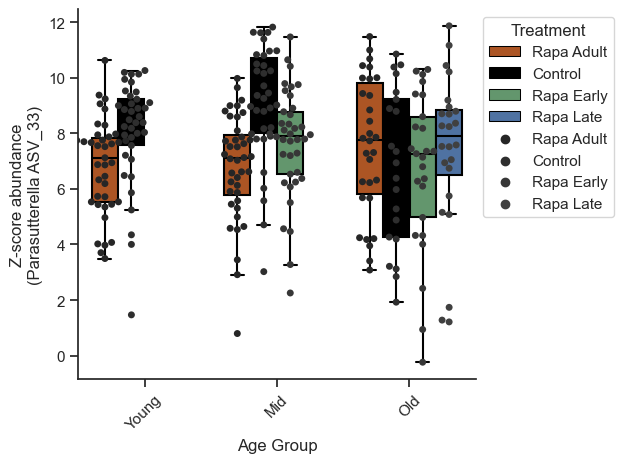

Romboutsia


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


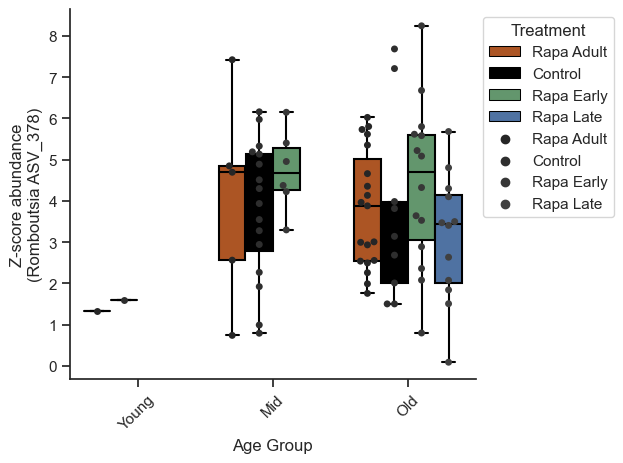

Lachnospiraceae_NK4A136_group


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


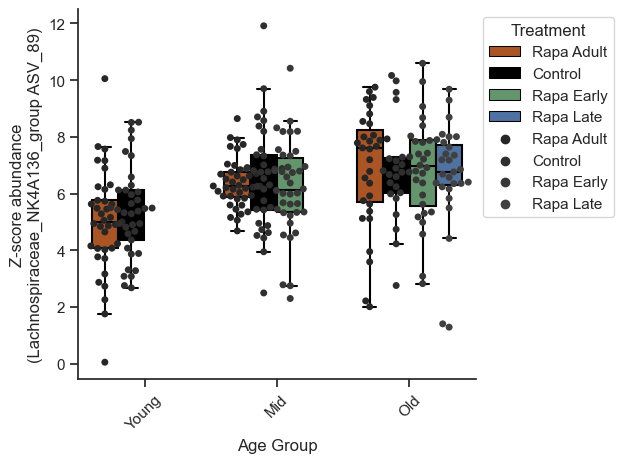

Staphylococcus


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


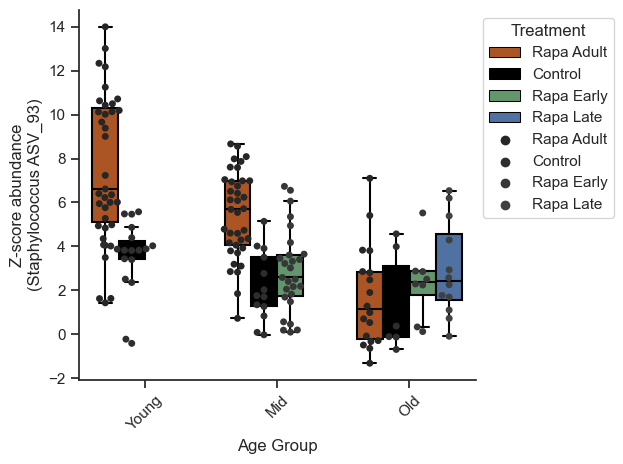

Muribaculaceae


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


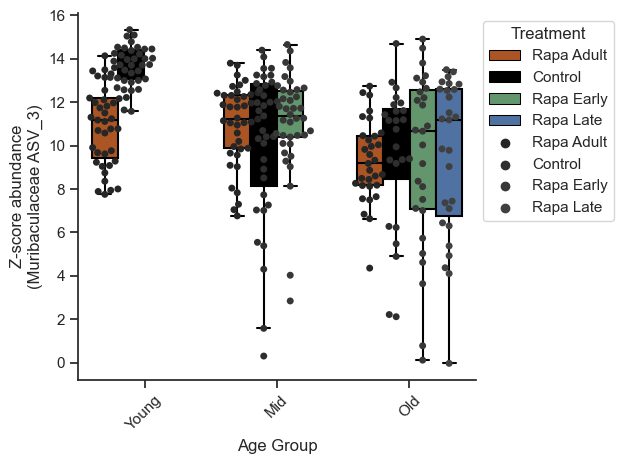

In [193]:
for e in list(ots.keys()):
    print(e)
    plot_expression(e)